In [48]:
import sys
import scipy.io.wavfile as wav
from scipy import stats as stats
import math
import numpy as np
import matplotlib.pyplot as plt
import struct
import pandas as pd
import itertools
import pyaudio
import wave
import sys
import hashlib
import rsa
import sha3
import Crypto
from Crypto.Hash import SHA256
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP
from Crypto import Random

In [49]:
N = 1038622
temparray = np.array([0.141592, 0.653589, 0.793238, 0.462643, 0.383279, 0.502884, 0.197169, 0.399375], dtype='double')
x = np.array([[0 for w in range(8)] for z in range (4)], dtype='double')
for y in range (8):
    x[0][y] = temparray[y]
L = 8
alpha = 1.99999
gamma = 4
epsilon = 0.05
s = 64
n = (2*N)/s
A = []
B = []
Pre = []
O = []
z = np.array([0 for w in range(7)])
weight = 0.5
b = 3

In [50]:
# # # # ZBIERANIE SZUMU Z MIKROFONU # # # #


# CHUNK = 1024
# FORMAT = pyaudio.paInt16
# CHANNELS = 2
# RATE = 44100
# RECORD_SECONDS = 10
# WAVE_OUTPUT_FILENAME = "output.wav"

# p = pyaudio.PyAudio()

# stream = p.open(format=FORMAT,
#                 channels=CHANNELS,
#                 rate=RATE,
#                 input=True,
#                 frames_per_buffer=CHUNK)

# print("* recording")

# frames = []

# for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
#     data = stream.read(CHUNK)
#     frames.append(data)

# print("* done recording")

# stream.stop_stream()
# stream.close()
# p.terminate()

# wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
# wf.setnchannels(CHANNELS)
# wf.setsampwidth(p.get_sample_size(FORMAT))
# wf.setframerate(RATE)
# wf.writeframes(b''.join(frames))
# wf.close()

In [51]:
# # # # FUNKCJE # # # #

def extract(data):
    with open(data, 'rb') as fh:
        bits = True
        i = 0
        while bits:
            i = i+1
            bits = fh.read(1)
            if (i>=10000):
                temp = (bin(int.from_bytes(bits, byteorder=sys.byteorder))[2:]).zfill(8)[5:]
                temppre = (bin(int.from_bytes(bits, byteorder=sys.byteorder))[2:]).zfill(8)
                tempMiBiS = (bin(int.from_bytes(bits, byteorder=sys.byteorder))[2:]).zfill(8)[7:]
                A.append(int(temp, 2))
                B.append(int(tempMiBiS, 2))
                Pre.append(int(temppre, 2))
            if (i==N):
                bits = False   

def perturbation(i, t, c):
    tempchaos = x[t][i]
    tempchaos = (((weight * A[c]) / ((2 ** b) - 1)) + tempchaos) * (1.0 / (1.0 + weight))
    x[t][i] = tempchaos

def chaosfun(i, t):
    if (x[t][i]<(0.5)):
        return alpha*x[t][i]
    else:
        return alpha * (1 - x[t][i])

def chaosmap(i, t):
    tempchaos = ((1 - epsilon) * chaosfun(i, t)) + ((epsilon / 2) * ((chaosfun((i + 1) % L, t)) + (chaosfun((i - 1) % L, t))))
    x[t+1][i] = tempchaos

def swap(number):
    # print(number)
    num = int(bin(number), 2)
    # print(num)
    mask = 0b11110000
    mask2 = 0b00001111
    tempmasked = mask & num
    temp1 = tempmasked >> 4
    tempmasked2 = mask2 & num
    temp2 = tempmasked2 << 4
    numero = temp1 | temp2
    # print(type(numero))
    return numero

def convert(num):
    temp = np.array([num], dtype='double')
    tamp = np.frombuffer(temp, dtype='uint8')
    return tamp[0]

def count_entropy(input):
    value,counts = np.unique(input, return_counts=True)
    # print(counts/sum(counts))
    end = 0
    for i in range(len(counts)):
        e = (counts[i]/sum(counts))*math.log2((counts[i]/sum(counts)))
        end = end + e
    entropy = -end
    return entropy

def toBytes(input):
    bytes = [sum([byte[b] << b for b in range(0,8)])
            for byte in zip(*(iter(input),) * 8)
        ]
    return bytes

def toBits(input):
    arr = list(map(int, input))
    for i in range(len(arr)):
        arr[i] = str(bin(arr[i])[2:]).zfill(3)
    temp = "".join(arr)
    return temp

def cutBitString(input):
    str = input
    bitarr = np.array([], 'int')
    temparr = [str[i:i+8] for i in range (0,(len(str)-len(str)%8),8)]
    print("Array length: ",len(temparr))
    for i in range (0, len(temparr)):
        bitarr = np.append(bitarr, int(temparr[i], 2))
        # if(i%5==0):
        #     print(i)
    return bitarr
    
def encrypt(message, key):
    return rsa.encrypt(message.encode('ascii'), key)

def decrypt(ciphertext, key):
    try:
        return rsa.decrypt(ciphertext, key).decode('ascii')
    except:
        return False

In [52]:
#GENERATOR LICZB PRAWDZIWIE LOSOWYCH

extract("output.wav")
counter = 0
while(counter < (N - 10008)):
    for i in range(L-1):
        perturbation(i, 0, counter)
        counter = counter + 1
    # print(x)
    # break
    for t in range(gamma - 1):
        for i in range(L - 1):
            chaosmap(i, t)
    # break
    # print(x)
    for i in range (L-1):
        z[i] = convert(x[gamma - 1][i])
        x[0][i] = x[gamma - 1][i]
    ztemp = 0
    # (L / 2) - 1 = 3
    for i in range(3):
        z[i] = np.uint8(int(bin(z[i]), 2)) ^ swap(z[i + int(L / 2)])
        O.append(z[i])

# Omess = O[0]<<8 | O[1]
# print(Omess)

# print(O)

In [53]:
import binascii
import os

with open('binaryStream.txt', 'wb') as f:
    np.save(f, O)

with open('binaryStream.txt', 'rb') as f:
    key = RSA.generate(1024,f.read)

public_key = key.publickey()

def isTrueCode(message, code):
    if(message == code):
        return True
    return False

#Wiadomosc do zaszyfrowania
Message = input("Podaj wiadomość A: ")
Message2 = Message
print("WIADOMOŚĆ A: ",Message)

#Haszowanie wiadomosci
hash_object = hashlib.sha256(str.encode(Message))
hex_dig = hash_object.hexdigest()
print('HASH #A: ',hex_dig, "\n")

#Kodowanie wiadomosci
encryptor = PKCS1_OAEP.new(public_key)
encrypted = encryptor.encrypt(str.encode(hex_dig))
print("Encrypted:", encrypted)

#Odkodowanie wiadomosci
decryptor = PKCS1_OAEP.new(key)
decrypted = decryptor.decrypt(encrypted)
decrypted = decrypted.decode("utf-8")
print('Decrypted:', decrypted)

#Porownanie
if(isTrueCode(hex_dig, decrypted)):
    print("Hash się zgadza. \n\n")
else:
    print("Hash się nie zgadza. \n\n")


#Kopia wiadomosci
messInput = input("Zmień wiadomość B (ENTER, by nie zmieniać):")
Message2 = Message2 + messInput
print("WIADOMOŚĆ B:", Message2)

#Haszowanie kopii wiadomosci
hash_object2 = hashlib.sha256(str.encode(Message2))
hex_dig2 = hash_object2.hexdigest()
print('HASH #B: ',hex_dig2, "\n")

#Porownanie
if(isTrueCode(hex_dig2, decrypted)):
    print("Hash się zgadza. \n\n")
else:
    print("Hash się nie zgadza. \n\n")


#Proba odkodowania innym kluczem
key2 = RSA.generate(1024)
print("Generowanie innego klucza...")
try:
    decryptor2 = PKCS1_OAEP.new(key2)
    decrypted2 = decryptor2.decrypt(encrypted)
    print('Decrypted:', decrypted2)
except:
    print("Nie działa z innym kluczem")

os.remove('binaryStream.txt')


WIADOMOŚĆ A:  A
HASH #A:  559aead08264d5795d3909718cdd05abd49572e84fe55590eef31a88a08fdffd 

Encrypted: b":\xe8\xee#-\xc7~\xd6q\xb3\x07\xa2J\x9b\x19\x00qm\xd0\xfa6\xbb\x89&J\xb1\xa3\x94\x98v4\x08\x95\xb2!99Gc\xbc!\xdb4w\xdfL\x12\n\xf9\xf3?\xfe{\xac\xa0\xe6j\t\x1df\x97B\x0f\xbedd\xc5\x89\x8b\xb0k\x07\x029W\xf4\xee<J\xb2\xc1g\xbe\xcb\xc9Q\xe2\xea^p\x01\xb1\xc2g\xe8F\x89^\x84~\xb6\x9cr\x1bC\x04\xb5{\xdd\xc8\xf7\xef^|\x0e\x9e\x02\xbd''Y\xaf\x08g\xe09\x04\xd8"
Decrypted: 559aead08264d5795d3909718cdd05abd49572e84fe55590eef31a88a08fdffd
Hash się zgadza. 


WIADOMOŚĆ B: A
HASH #B:  559aead08264d5795d3909718cdd05abd49572e84fe55590eef31a88a08fdffd 

Hash się zgadza. 


Generowanie innego klucza...
Nie działa z innym kluczem


In [54]:
#POST-PROCESSING MiBiS&XOR

# arrMiBiS = np.array([], dtype = 'int')
# arrMiBiS = np.append(arrMiBiS, B[0])
# arrMiBiS = np.append(arrMiBiS, B[1])
# arrMiBiS = np.insert(arrMiBiS, 1, B[2])
# step=3
# i=3
# control = (2**step) + 1
# while((i <= len(B)) and (control < len(B))):
#     control = (2**step) + 1
#     newBits = 2**(step-2)
#     counterOdd = 2
#     counterEven = 2
#     for j in range ((int(newBits/2))-1):
#         arrMiBiS = np.insert(arrMiBiS, counterOdd, B[i])
#         arrMiBiS = np.insert(arrMiBiS, -counterEven, B[i+1])
#         counterOdd = counterOdd + 2
#         counterEven = counterEven + 2
#         i = i+2
#     step = step + 1
#     i = i+1

# counterXOR = 0
# p = np.array([], dtype = 'int')
# while(counterXOR < len(arrMiBiS)):
#     XORek = arrMiBiS[counterXOR] ^ B[counterXOR]
#     p = np.append(p, XORek)
#     counterXOR = counterXOR + 1
# # print(p)
# bajty = toBytes(p)
# # print(bajty)

385733
Entropia Chaosmap: 7.999642772733402


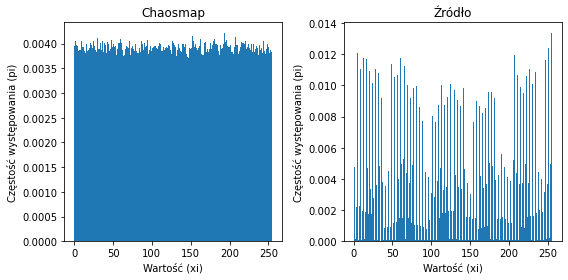

In [56]:
#OUTPUT

bithist = toBits(A)
result = cutBitString(bithist)

print("Entropia Chaosmap:", count_entropy(O))
# print("Entropia MiBiS&XOR:", count_entropy(bajty))
# print("Entropia szumu na wyjściu mikrofonu:", count_entropy(Pre))
# print("Entropia źródła:", count_entropy(result))




fig, axs = plt.subplots(1,2, figsize = (8, 4))
# fig, axs = plt.subplots(1,3, figsize = (16, 4))
axs[0].hist(O, bins=256, density = True)
axs[0].set_title('Chaosmap')
axs[0].set_xlabel('Wartość (xi)')
axs[0].set_ylabel('Częstość występowania (pi)')
axs[1].hist(result, bins=256, density = True)
axs[1].set_title('Źródło')
axs[1].set_xlabel('Wartość (xi)')
axs[1].set_ylabel('Częstość występowania (pi)')
# axs[2].hist(bajty, bins=256, density = True)
# axs[2].set_title('MiBiS&XoR')
# axs[2].set_xlabel('Wartość (xi)')
# axs[2].set_ylabel('Częstość występowania (pi)')
plt.tight_layout()
plt.show()
